In [3]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qr_methods import generateGaussData, findAdjustedAlpha, findLambForCoverage, runQR, levelAdjWRegTuning

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
### Evaluate regularized and unregularized level tuning in terms of coverage and 
### accuracy of fitted coefficients
def oneLevelRegTuningExperiment(nTrain, nTest, d, alpha, minlamb, maxlamb, numlamb,
                                sigma_sq_eps = 1, verbose=False):

    XTrain, YTrain, XTest, YTest, betastar = generateGaussData(nTrain, nTest, d)


    ### Tuning the level
    alphaAdj = findAdjustedAlpha(XTrain,YTrain,alpha,0)
    if verbose:
        print('Tuned Alpha: ', alphaAdj, ' Parameters: ', (XTrain.shape))
    beta0AlphaAdj, betaAlphaAdj, _ = runQR(XTrain,YTrain,alphaAdj,0)
    covAlphaAdj = np.mean(YTest <= beta0AlphaAdj + XTest@betaAlphaAdj)
    accAlphaAdj = np.sqrt(sum((betastar - betaAlphaAdj)**2))

    ### Tuning regularization 
    optLamb = findLambForCoverage(XTrain,YTrain,alpha)
    if verbose:
        print('Tuned Lambda: ', optLamb, ' Parameters: ', (XTrain.shape))
    beta0LambAdj, betaLambAdj, _ = runQR(XTrain,YTrain,alpha,optLamb)
    covLambAdj = np.mean(YTest <= beta0LambAdj + XTest@betaLambAdj)
    accLambAdj = np.sqrt(sum((betastar - betaLambAdj)**2))

    ### Tuning both
    alphaMAS, lambMAS = levelAdjWRegTuning(XTrain,YTrain,alpha,minlamb,maxlamb,numlamb)
    if verbose:
        print('MAS Search Results: ', (alphaMAS, lambMAS), ' Parameters: ', (XTrain.shape))
    beta0MAS, betaMAS, _ = runQR(XTrain,YTrain,alphaMAS,lambMAS)
    covMAS = np.mean(YTest <= beta0MAS + XTest@betaMAS)
    accMAS = np.sqrt(sum((betastar - betaMAS)**2))


    res = pd.DataFrame({'Number of Training Points' : [nTrain]*3,
                        'Dimension': [d]*3,
                        'Coverage': [covAlphaAdj,covLambAdj,covMAS],
                        'Accuracy': [accAlphaAdj,accLambAdj,accMAS],
                        'Method': ['Adjusted Level', 'Adjusted Regularization', 'Adjusted Level with Regularization'],
                        'Selected Params': [1-alphaAdj, optLamb, lambMAS]
                       })
    return res


nTrials = 100
nTrain = 200
nTest = 2000
ds = [1,10,20,30,40,50]
alpha = 0.1
minlamb = 0
maxlamb = 0.1
numlamb = 21


res = pd.DataFrame()
for i in tqdm(range(nTrials)):
    for d in ds:
        resOne = oneLevelRegTuningExperiment(nTrain, nTest, d, alpha, minlamb, maxlamb, numlamb, verbose=False)
        res = pd.concat([res,resOne])

100%|██████████| 100/100 [1:43:47<00:00, 62.27s/it]


In [8]:
res.to_csv('FinalLevelRegResults.csv')

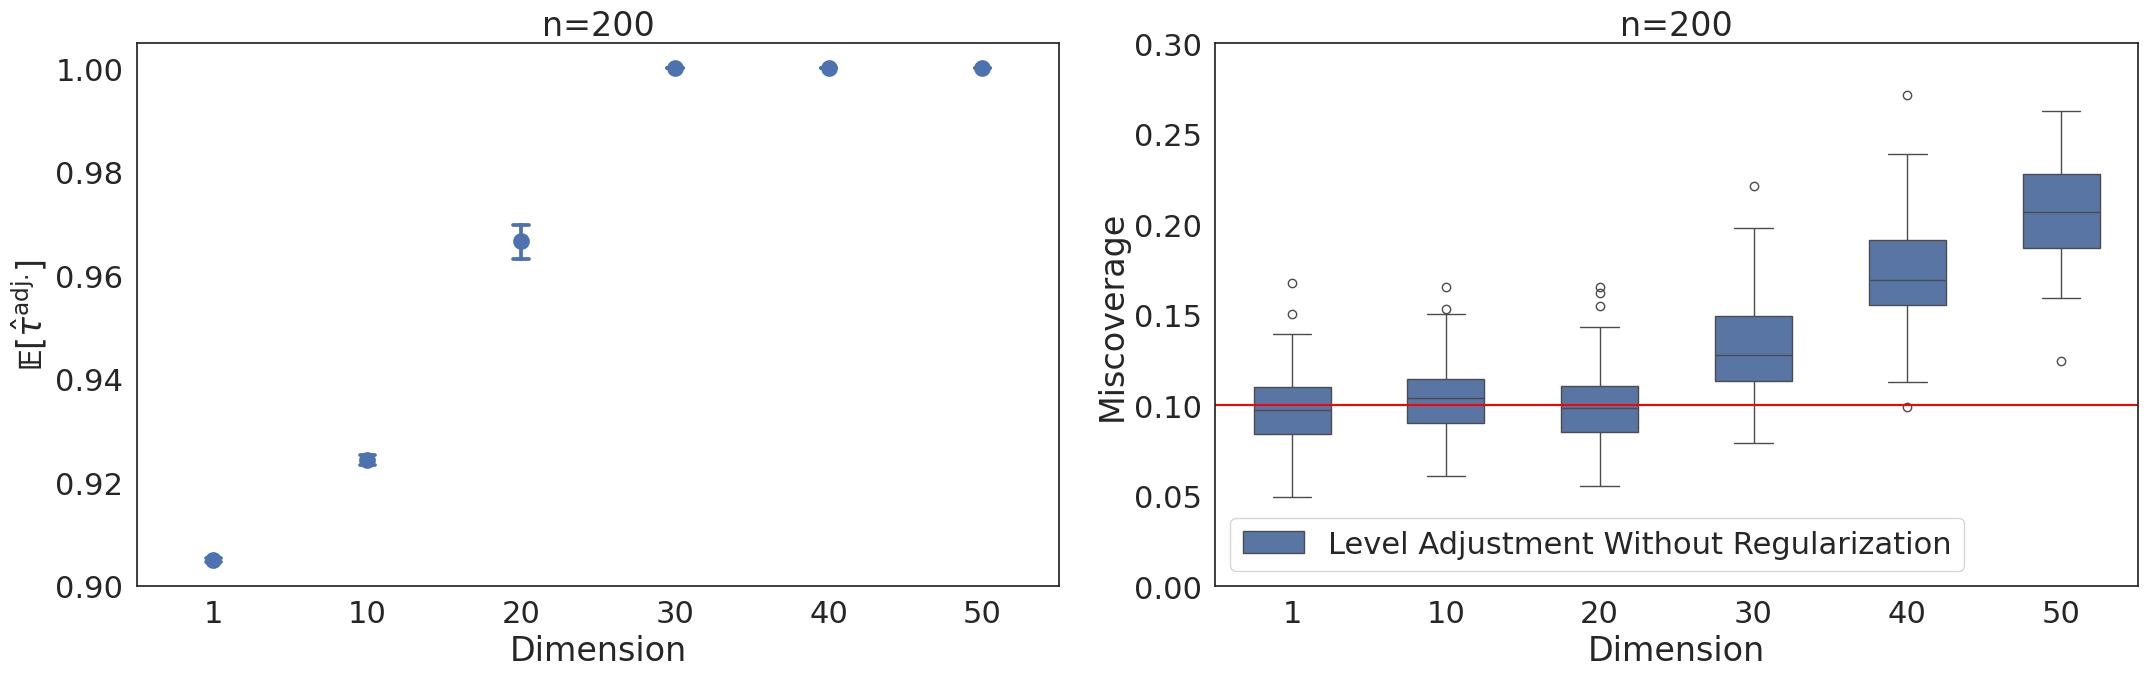

In [5]:
sns.set(rc={'figure.figsize':(22,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1-res['Coverage']
res.loc[res['Method'] == 'Adjusted Level with Regularization', 'Method'] = 'Level Adjustment with Regularization'
res.loc[res['Method'] == 'Adjusted Level', 'Method'] = 'Level Adjustment Without Regularization'
res.loc[res['Method'] == 'Adjusted Regularization', 'Method'] = 'Fixed Level with Regularization'

ax1 = fig.add_subplot(1,2,1)
f1 = sns.pointplot(res[res['Method'] == 'Level Adjustment Without Regularization'],
                   x='Dimension',y='Selected Params',
    marker='o',
    linestyle='none',
    errorbar=('ci', 95),
    markersize=10,
    capsize=0.1,
    ax = ax1,
    hue = 'Method'
)
ax1.set_ylabel(r"$\mathbf{\mathbb{E}}[\hat{\tau}^{\text{adj.}}]$")
ax1.set_title('n=200')

ax2 = fig.add_subplot(1,2,2)
f2 = sns.boxplot(res[res['Method'] == 'Level Adjustment Without Regularization'],x='Dimension',
                 y='Miscoverage',hue='Method',ax=ax2,width=0.5)
f2.axhline(alpha, color='red')
ax2.get_legend().set_title('')
ax2.set_title('n=200')

ax1.legend_.remove()
ax2.set_ylim(0,0.3)

plt.tight_layout()

plt.savefig("figures/LevelTuning.pdf",bbox_inches='tight')

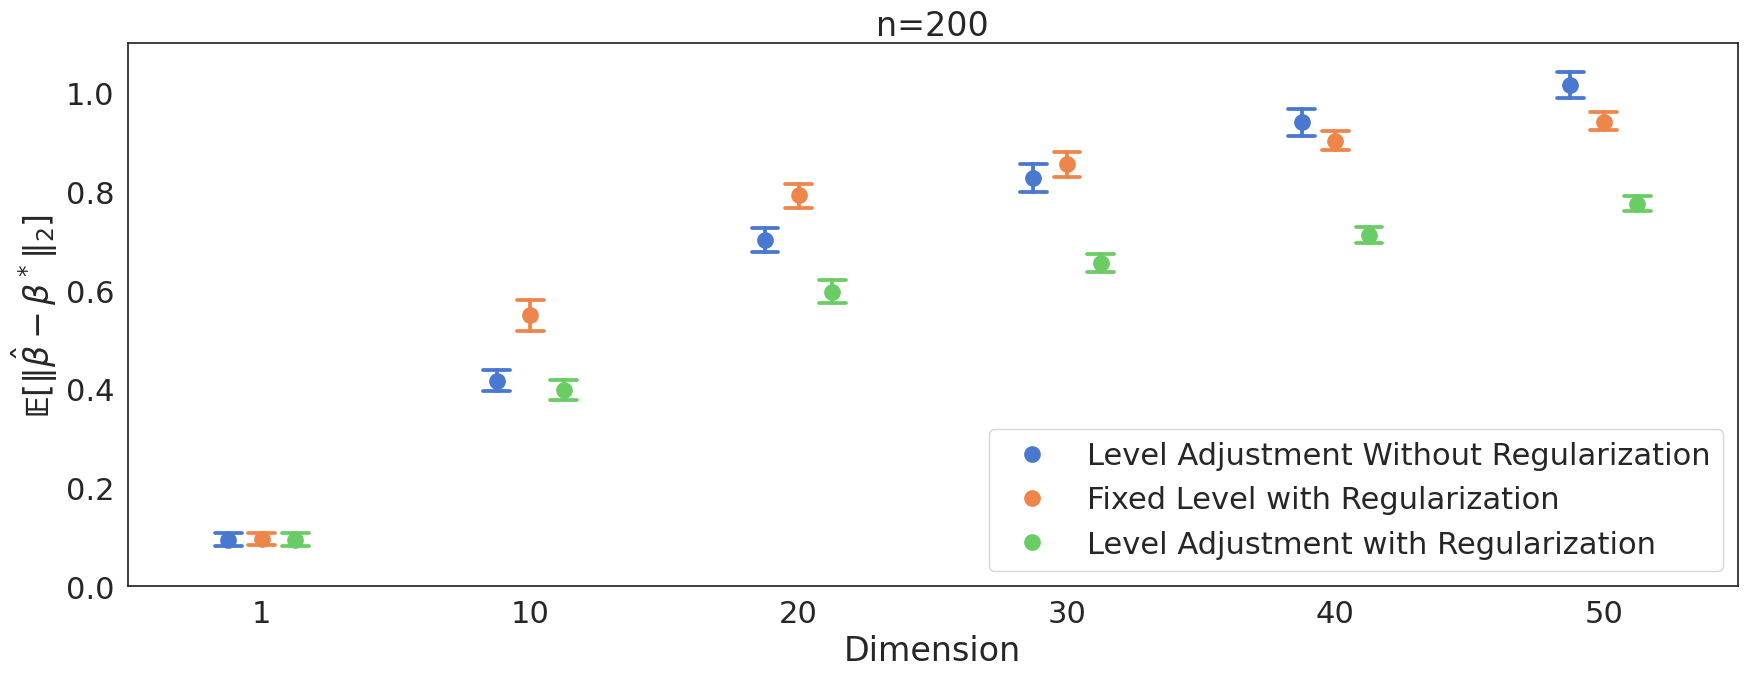

In [6]:
sns.set(rc={'figure.figsize':(18,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')

my_pal3 = {"Fixed Level with Regularization": sns.color_palette("muted")[:][1],
         "Level Adjustment with Regularization": sns.color_palette("muted")[:][2],
         "Level Adjustment Without Regularization": sns.color_palette("muted")[:][0]
         }
f3 = sns.pointplot(
    data=res,
    x='Dimension',
    y='Accuracy',
    marker='o',
    linestyle='none',
    errorbar=('ci', 95),
    markersize=10,
    capsize=0.1,
    dodge=0.25,
    palette=my_pal3,
    hue = 'Method'
)
plt.legend().set_title('')
plt.ylabel(r"$\mathbf{\mathbb{E}}[\|\hat{\beta} - \beta^*\|_2]$")
plt.title('n=200')

plt.ylim(0,1.1)

plt.tight_layout()

plt.savefig("figures/RegVersusRegLevelTuning.pdf",bbox_inches='tight')